# 🧠 SHAP Visualizations — Interactive Class Notebook  
*Author: [Your Name] | Course: Advanced Machine Learning (Explainability Session)*  

---

## 🎯 Objective
This notebook demonstrates how **SHAP (SHapley Additive exPlanations)** can explain model predictions, both **globally** (which features matter most overall) and **locally** (why a specific prediction happened).  

We’ll start simple and build progressively:
1. **Data Setup:** UCI Adult Income dataset — predict if income > \$50K.  
2. **Modeling:** Logistic Regression and XGBoost (linear vs. tree-based).  
3. **Explainability:**  
   - Global feature importance (bar, beeswarm).  
   - Local explanations (force plots, decision plots, waterfall).  
   - Dependence and interaction effects.  

---

## 🗂️ Dataset Plan
**Dataset:** `adult` from OpenML.  
- **Features:** Mixed (numeric + categorical).  
- **Target:** `income` (binary: `>50K` / `<=50K`).  
- Ideal for explaining different model types and discussing bias/fairness.

**Fallback Option:** If OpenML is slow, switch to `fetch_california_housing()` (regression).

---

## 🧩 Roadmap for Notebook
| Step | Description |
|------|--------------|
| 1 | Install & verify libraries |
| 2 | Load and preprocess dataset |
| 3 | Train models |
| 4 | Compute and visualize SHAP values |
| 5 | Interpret and discuss results |

---

## 🧰 Environment Check
We’ll confirm versions of all relevant libraries and ensure SHAP is working properly before training any models.


In [2]:
# ------------------------------------------------------------
# Block 1: Environment Check & Dataset Download
# ------------------------------------------------------------
# This cell:
# 1) Imports all required libraries.
# 2) Prints their versions for debugging consistency.
# 3) Downloads the UCI Adult dataset from OpenML.
# 4) Displays shape and head to confirm structure.
# ------------------------------------------------------------

import sys
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import shap

# Optional model libraries
try:
    import xgboost
except ImportError:
    xgboost = None

try:
    import lightgbm
except ImportError:
    lightgbm = None

try:
    import catboost
except ImportError:
    catboost = None

# Print version info for environment consistency
print("✅ Environment Check")
print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"SHAP version: {shap.__version__}")
print(f"XGBoost version: {getattr(xgboost, '__version__', 'Not installed')}")
print(f"LightGBM version: {getattr(lightgbm, '__version__', 'Not installed')}")
print(f"CatBoost version: {getattr(catboost, '__version__', 'Not installed')}")

# ------------------------------------------------------------
# Dataset loading
# ------------------------------------------------------------
from sklearn.datasets import fetch_openml

print("\n📥 Downloading Adult dataset from OpenML...")
adult = fetch_openml("adult", as_frame=True)
df = adult.frame

print(f"✅ Dataset loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns\n")
print(df.head())

✅ Environment Check
Python version: 3.13.5
NumPy version: 2.3.3
Pandas version: 2.3.3
Matplotlib version: 3.10.6
scikit-learn version: 1.7.2
SHAP version: 0.48.0
XGBoost version: 3.0.5
LightGBM version: 4.6.0
CatBoost version: 1.2.8

📥 Downloading Adult dataset from OpenML...
✅ Dataset loaded successfully: 48842 rows × 15 columns

  age         workclass  fnlwgt  education  education-num      marital-status  \
0   2         State-gov   77516  Bachelors             13       Never-married   
1   3  Self-emp-not-inc   83311  Bachelors             13  Married-civ-spouse   
2   2           Private  215646    HS-grad              9            Divorced   
3   3           Private  234721       11th              7  Married-civ-spouse   
4   1           Private  338409  Bachelors             13  Married-civ-spouse   

          occupation   relationship   race     sex capitalgain capitalloss  \
0       Adm-clerical  Not-in-family  White    Male           1           0   
1    Exec-managerial    

c:\Users\murth\Desktop\DBA-code\.venv\Lib\site-packages\sklearn\datasets\_openml.py:328: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=179
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=1590

  warn(warning_msg)


## 🔧 Fix: Handling Target Column Name Differences

Different OpenML mirrors label the target column as either `income` or `class`.  
We’ll detect it automatically and rename it to a consistent `income` for clarity.


In [3]:
# ------------------------------------------------------------
# Block 1b: Fix target column name & verify
# ------------------------------------------------------------
# This block detects whether the dataset target is 'class' or 'income',
# renames it uniformly to 'income', and rechecks everything.
# ------------------------------------------------------------

# Find target column (either 'income' or 'class')
target_col = None
for cand in ["income", "class"]:
    if cand in df.columns:
        target_col = cand
        break

if target_col is None:
    raise ValueError("Target column not found! Available columns:", df.columns.tolist())

# Standardize target name
if target_col != "income":
    df = df.rename(columns={target_col: "income"})

print(f"✅ Target column standardized as 'income'. Shape: {df.shape}")
print("\n🎯 Target distribution:")
print(df["income"].value_counts(normalize=True))

# Peek at column names
print("\n📋 Feature columns:")
print(df.columns.tolist()[:10], "...")


✅ Target column standardized as 'income'. Shape: (48842, 15)

🎯 Target distribution:
income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

📋 Feature columns:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex'] ...


## ⚙️ Block 2 — Preprocessing Pipeline Setup

Now that the dataset loads cleanly, let’s prepare it for modeling.

We’ll:
1. **Separate features (X)** and **target (y)**.  
2. **Split** into training and test sets (stratified).  
3. Identify **numeric** and **categorical** columns.  
4. Build a **ColumnTransformer** that:
   - scales numeric features (`StandardScaler`);
   - one-hot encodes categorical features (`OneHotEncoder(handle_unknown='ignore')`).
5. Transform the data into model-ready NumPy arrays and store clean feature names for SHAP visualizations later.

> 💡 Note: Tree models like XGBoost or LightGBM don’t need scaling, but it doesn’t hurt and keeps preprocessing consistent for linear models.


In [4]:
# ------------------------------------------------------------
# Block 2: Preprocessing setup
# ------------------------------------------------------------
# We will:
# 1) Split the data into X (features) and y (target).
# 2) Identify numeric and categorical columns.
# 3) Build a ColumnTransformer with StandardScaler + OneHotEncoder.
# 4) Fit-transform the training set and transform the test set.
# ------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate features and target
X = df.drop(columns=["income"])
y = df["income"].apply(lambda x: 1 if ">50K" in x else 0)

# Train/test split with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Train shape: {X_train.shape},  Test shape: {X_test.shape}")

# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"📊 Numeric columns: {len(num_cols)}")
print(f"🔤 Categorical columns: {len(cat_cols)}")

# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)

# Fit-transform training data and transform test data
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

print(f"✅ Preprocessing complete.  Transformed shapes:")
print(f"X_train_pre: {X_train_pre.shape},  X_test_pre: {X_test_pre.shape}")

# Retrieve expanded feature names (for SHAP plotting later)
# After OneHotEncoder, categorical columns expand into multiple dummy features.
num_features = num_cols
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

print(f"🔖 Total feature names after encoding: {len(feature_names)}")
print("Example:", feature_names[:10])


✅ Train shape: (39073, 14),  Test shape: (9769, 14)
📊 Numeric columns: 2
🔤 Categorical columns: 12
✅ Preprocessing complete.  Transformed shapes:
X_train_pre: (39073, 124),  X_test_pre: (9769, 124)
🔖 Total feature names after encoding: 124
Example: ['fnlwgt' 'education-num' 'age_0' 'age_1' 'age_2' 'age_3' 'age_4'
 'workclass_Federal-gov' 'workclass_Local-gov' 'workclass_Never-worked']


## 🚀 Block 3 — Train Baseline Models (Logistic Regression + Tree Model) and Evaluate

**Why two models?**  
- **Logistic Regression (LR)** is linear and easy to reason about; SHAP on LR mirrors weighted contributions after preprocessing.  
- A **tree-based model** (preferably **XGBoost**; else we’ll auto-fallback to **RandomForest**) captures non-linearities and interactions where SHAP visualizations (beeswarm, dependence) are especially insightful.

**What this block does:**  
1) Trains **LR** on `X_train_pre`.  
2) Trains a **tree model**: **XGBoost** if available, otherwise **RandomForest**.  
3) Evaluates both on the test set with **Accuracy, ROC-AUC, F1**, plus a **classification report**.  
4) Stores fitted models (and keeps `preprocessor`) for the upcoming SHAP blocks.

**Outputs to look at:**  
- Basic metrics to ensure models aren’t broken.  
- Quick peek at top positive/negative LR coefficients to build intuition before SHAP.


In [5]:
# ------------------------------------------------------------
# Block 3: Baseline models + evaluation
# ------------------------------------------------------------
# Trains:
#  - LogisticRegression (linear baseline)
#  - XGBoost (if installed) else RandomForest (tree baseline)
# Evaluates with accuracy, ROC-AUC, F1, and a classification report.
# Keeps models for SHAP exploration in later blocks.
# ------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 1) Logistic Regression (liblinear handles smaller problems; saga handles larger + l1/l2)
log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=200,
    n_jobs=None  # n_jobs not used by lbfgs
)
log_reg.fit(X_train_pre, y_train)

y_prob_lr = log_reg.predict_proba(X_test_pre)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)

print("==== Logistic Regression ====")
print(f"Accuracy   : {accuracy_score(y_test, y_pred_lr):.4f}")
# Guard ROC-AUC for degenerate predictions
try:
    print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob_lr):.4f}")
except ValueError:
    print("ROC-AUC    : could not compute (only one class predicted).")
print(f"F1-score   : {f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification report (LR):")
print(classification_report(y_test, y_pred_lr, digits=4))

# Quick interpretability sanity check for LR: top positive/negative coefficients
# (Only works cleanly because we retained feature_names from preprocessing)
coef = log_reg.coef_.ravel()
sorted_idx = np.argsort(coef)
print("\nTop 10 negative LR coefficients (push toward <=50K):")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]:40s} {coef[i]: .4f}")
print("\nTop 10 positive LR coefficients (push toward >50K):")
for i in sorted_idx[-10:][::-1]:
    print(f"{feature_names[i]:40s} {coef[i]: .4f}")

# 2) Tree-based model: prefer XGBoost if present; else RandomForest
tree_model_name = None
tree_model = None

if 'xgboost' in globals() and xgboost is not None:
    from xgboost import XGBClassifier
    tree_model = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.075,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        tree_method="hist"  # faster on CPUs; use "gpu_hist" if GPU available
    )
    tree_model_name = "XGBoost"
else:
    # Fallback: RandomForest (solid non-linear baseline when xgboost isn't installed)
    tree_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    tree_model_name = "RandomForest (fallback)"

tree_model.fit(X_train_pre, y_train)
y_prob_tree = tree_model.predict_proba(X_test_pre)[:, 1]
y_pred_tree = (y_prob_tree >= 0.5).astype(int)

print(f"\n==== {tree_model_name} ====")
print(f"Accuracy   : {accuracy_score(y_test, y_pred_tree):.4f}")
try:
    print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob_tree):.4f}")
except ValueError:
    print("ROC-AUC    : could not compute (only one class predicted).")
print(f"F1-score   : {f1_score(y_test, y_pred_tree):.4f}")
print(f"\nClassification report ({tree_model_name}):")
print(classification_report(y_test, y_pred_tree, digits=4))

# Keep references for SHAP blocks
models = {
    "logistic_regression": log_reg,
    "tree_model": tree_model,
    "tree_model_name": tree_model_name
}
print("\n✅ Models trained and ready for SHAP.")


==== Logistic Regression ====
Accuracy   : 0.8606
ROC-AUC    : 0.9132
F1-score   : 0.6786

Classification report (LR):
              precision    recall  f1-score   support

           0     0.8856    0.9378    0.9110      7431
           1     0.7568    0.6151    0.6786      2338

    accuracy                         0.8606      9769
   macro avg     0.8212    0.7764    0.7948      9769
weighted avg     0.8548    0.8606    0.8554      9769


Top 10 negative LR coefficients (push toward <=50K):
capitalgain_1                            -2.8886
capitalgain_0                            -2.4951
age_0                                    -1.3264
native-country_South                     -1.3079
capitalgain_2                            -1.2598
occupation_Priv-house-serv               -1.0988
native-country_Columbia                  -1.0191
capitalloss_0                            -0.9528
marital-status_Never-married             -0.8803
hoursperweek_0                           -0.8795

Top 10 po

## 🌈 Block 4 — Global SHAP Explanations (Bar + Beeswarm)

Now that our models are trained, let’s use **SHAP** to explain *feature importance* across all predictions.

### 🎯 Goals
1. **Compute SHAP values** for both models (Logistic Regression & XGBoost/Tree).  
2. **Visualize** global feature importance:
   - **Bar plot** → average absolute SHAP values (mean impact).  
   - **Beeswarm plot** → distribution of impacts per feature.  
3. **Interpret results:**
   - Which features *increase or decrease* the probability of income > \$50K?
   - Do SHAP global rankings roughly align with Logistic Regression coefficients?

### 💡 Notes
- For linear models, SHAP ≈ feature weight × feature value.
- For tree models, SHAP uses **TreeExplainer**, which efficiently computes exact Shapley values.
- SHAP plots require the **original feature names** (not encoded integers), so we’ll pass transformed feature names we built earlier.


⚡ Computing SHAP values for Logistic Regression...

📊 Logistic Regression — Mean |SHAP| (Feature Importance)


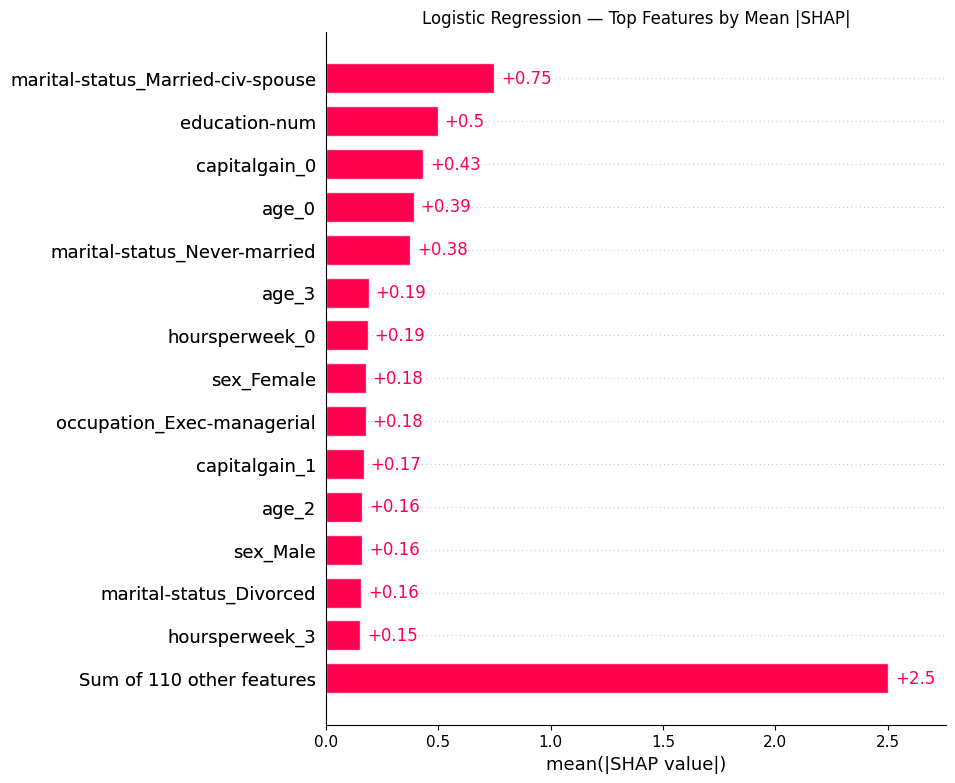


🐝 Logistic Regression — Beeswarm Plot


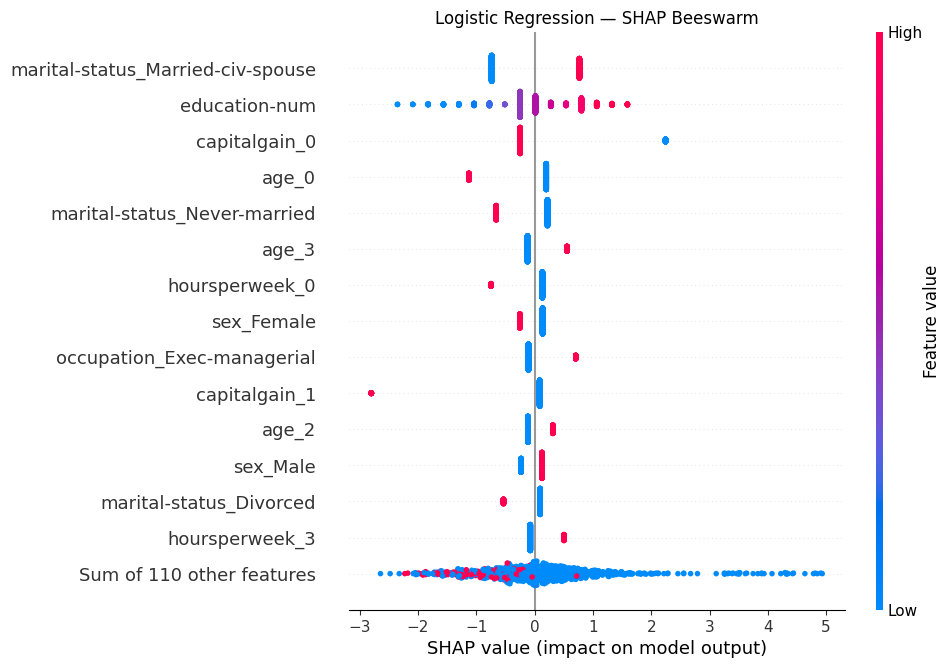


⚡ Computing SHAP values for XGBoost...

📊 XGBoost — Mean |SHAP| (Feature Importance)


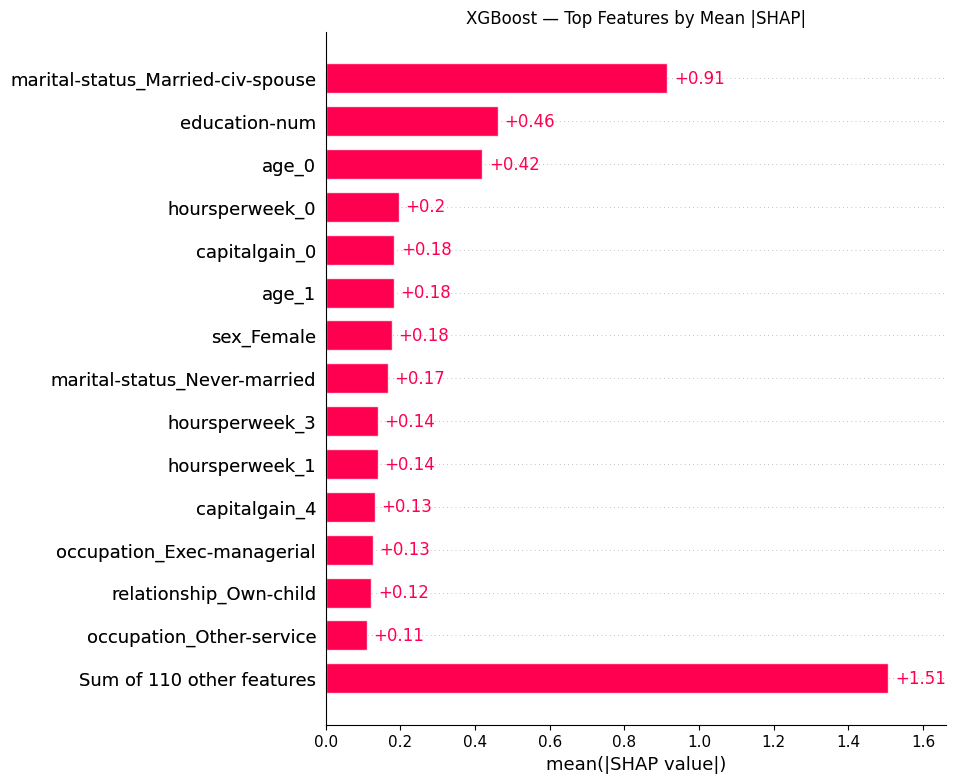


🐝 XGBoost — Beeswarm Plot


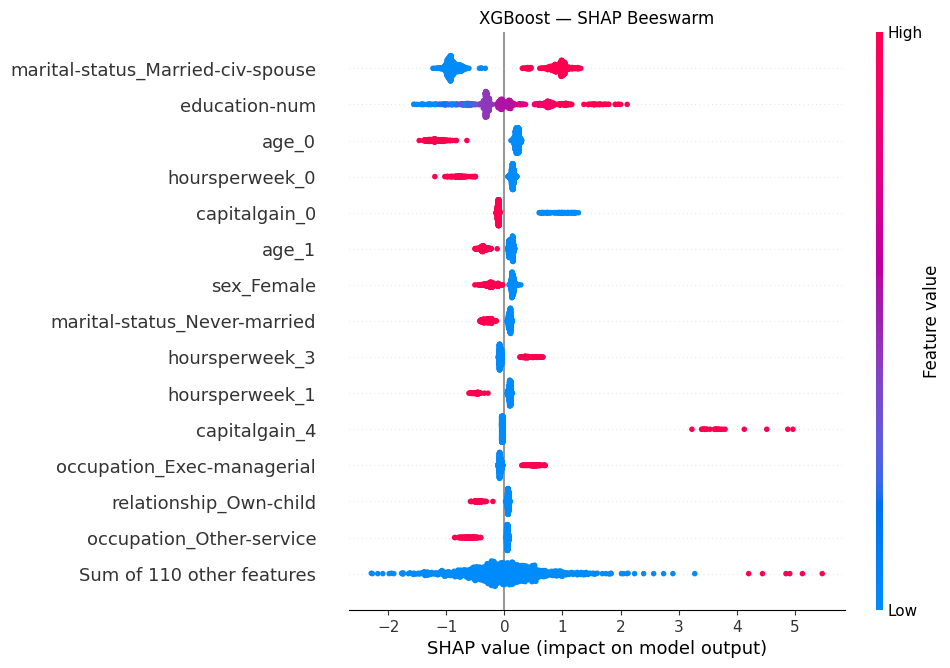

In [6]:
# ------------------------------------------------------------
# Block 4: Global SHAP explanations (bar + beeswarm)
# ------------------------------------------------------------
# We will:
# 1) Initialize SHAP explainers for both models.
# 2) Compute SHAP values on a subset of the test set (for speed).
# 3) Plot bar and beeswarm visualizations.
# ------------------------------------------------------------

import shap
import matplotlib.pyplot as plt

# Use only a subset for visualization (SHAP can be slow on full test sets)
sample_size = 1000
X_sample = X_test_pre[:sample_size]
y_sample = y_test[:sample_size]

# --- Logistic Regression SHAP ---
print("⚡ Computing SHAP values for Logistic Regression...")
explainer_lr = shap.Explainer(models["logistic_regression"], X_train_pre, feature_names=feature_names)
shap_values_lr = explainer_lr(X_sample)

# Plot: mean absolute SHAP value per feature (global importance)
print("\n📊 Logistic Regression — Mean |SHAP| (Feature Importance)")
shap.plots.bar(shap_values_lr, max_display=15, show=False)
plt.title("Logistic Regression — Top Features by Mean |SHAP|")
plt.show()

# Plot: Beeswarm (global distribution)
print("\n🐝 Logistic Regression — Beeswarm Plot")
shap.plots.beeswarm(shap_values_lr, max_display=15, show=False)
plt.title("Logistic Regression — SHAP Beeswarm")
plt.show()

# --- Tree Model SHAP ---
print(f"\n⚡ Computing SHAP values for {models['tree_model_name']}...")
explainer_tree = shap.Explainer(models["tree_model"], X_train_pre, feature_names=feature_names)
shap_values_tree = explainer_tree(X_sample)

# Plot: mean absolute SHAP value per feature
print(f"\n📊 {models['tree_model_name']} — Mean |SHAP| (Feature Importance)")
shap.plots.bar(shap_values_tree, max_display=15, show=False)
plt.title(f"{models['tree_model_name']} — Top Features by Mean |SHAP|")
plt.show()

# Plot: Beeswarm (distribution)
print(f"\n🐝 {models['tree_model_name']} — Beeswarm Plot")
shap.plots.beeswarm(shap_values_tree, max_display=15, show=False)
plt.title(f"{models['tree_model_name']} — SHAP Beeswarm")
plt.show()


## 🔍 Block 5 — Local SHAP Explanations (Force + Waterfall)

In this block we’ll **explain individual predictions** for both models:

**What we’ll do**
- Pick two representative test samples:
  - **High-probability positive** (model thinks `>50K` income is likely)
  - **Low-probability positive** (model thinks `<=50K` is likely)
- Compute **SHAP values** for those instances.
- Visualize **why** the model predicted what it did using:
  - **Force plot** (push/pull from the base value to the prediction)
  - **Waterfall plot** (ordered contributions, great for teaching)

**Reading the plots**
- The **base value** is the model’s average output on the reference data.
- **Red bars** push the prediction **up** (toward `>50K`), **blue bars** push it **down**.
- For one-hot categorical features, look for the active dummy among the group.

> Tip for class: Compare **Logistic Regression** vs **Tree Model** explanations for the **same row** to show how model class changes the story.


Selected instances based on Tree model probabilities:
XGBoost (HIGH) — idx=191, predicted P(>50K) = 0.9988
XGBoost (LOW) — idx=758, predicted P(>50K) = 0.0005

XGBoost High-Prob — Top Contributors:
capitalgain_4                            ↑ +3.5396
capitalgain_0                            ↑ +1.1542
education-num                            ↑ +1.0940
occupation_Exec-managerial               ↑ +0.5962
hoursperweek_3                           ↑ +0.4225
marital-status_Married-civ-spouse        ↑ +0.4016
age_0                                    ↑ +0.2874
hoursperweek_0                           ↑ +0.2102
fnlwgt                                   ↑ +0.1724
education_Masters                        ↑ +0.1326

XGBoost Low-Prob — Top Contributors:
age_0                                    ↓ -1.1753
marital-status_Married-civ-spouse        ↓ -0.9441
hoursperweek_0                           ↓ -0.8073
relationship_Own-child                   ↓ -0.4663
marital-status_Never-married             ↓ -0.3701

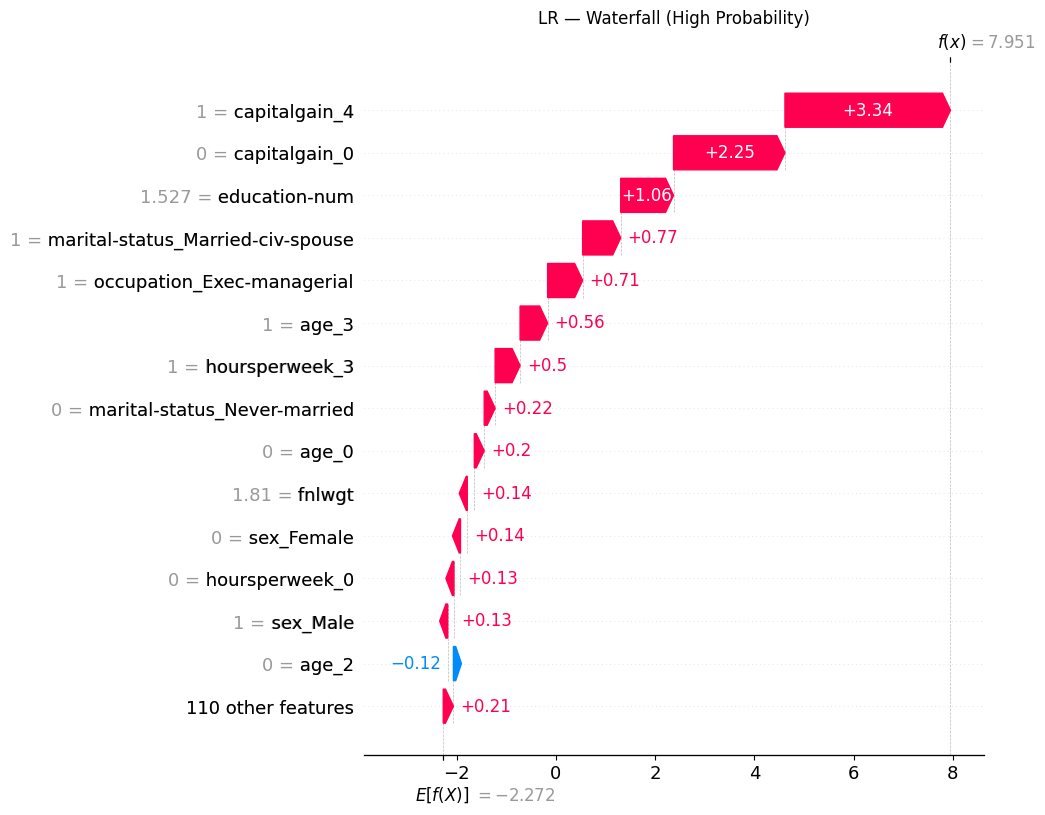


=== Logistic Regression: LOW probability case ===


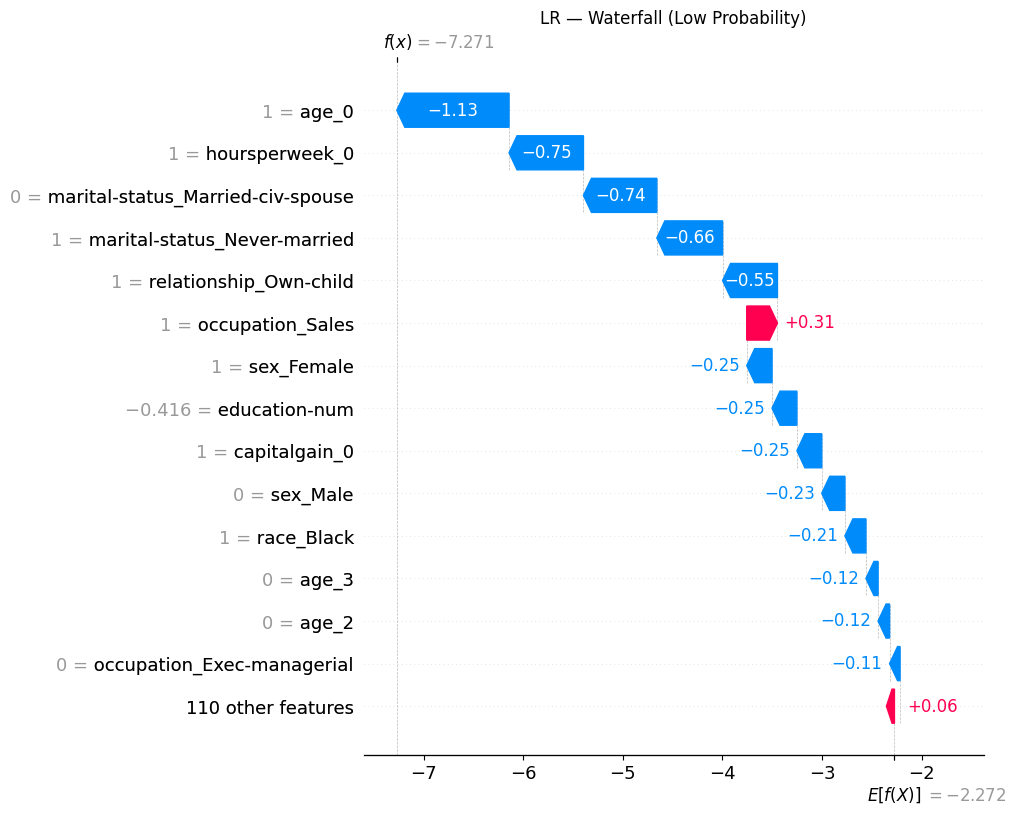


=== XGBoost: HIGH probability case ===


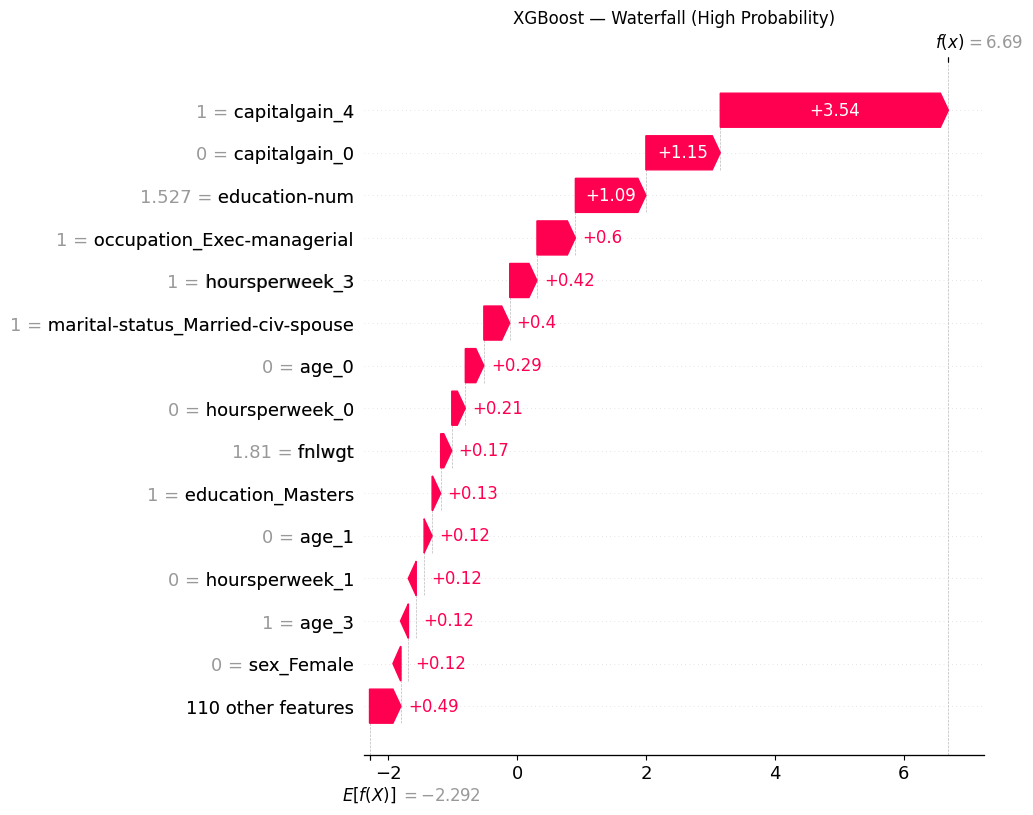


=== XGBoost: LOW probability case ===


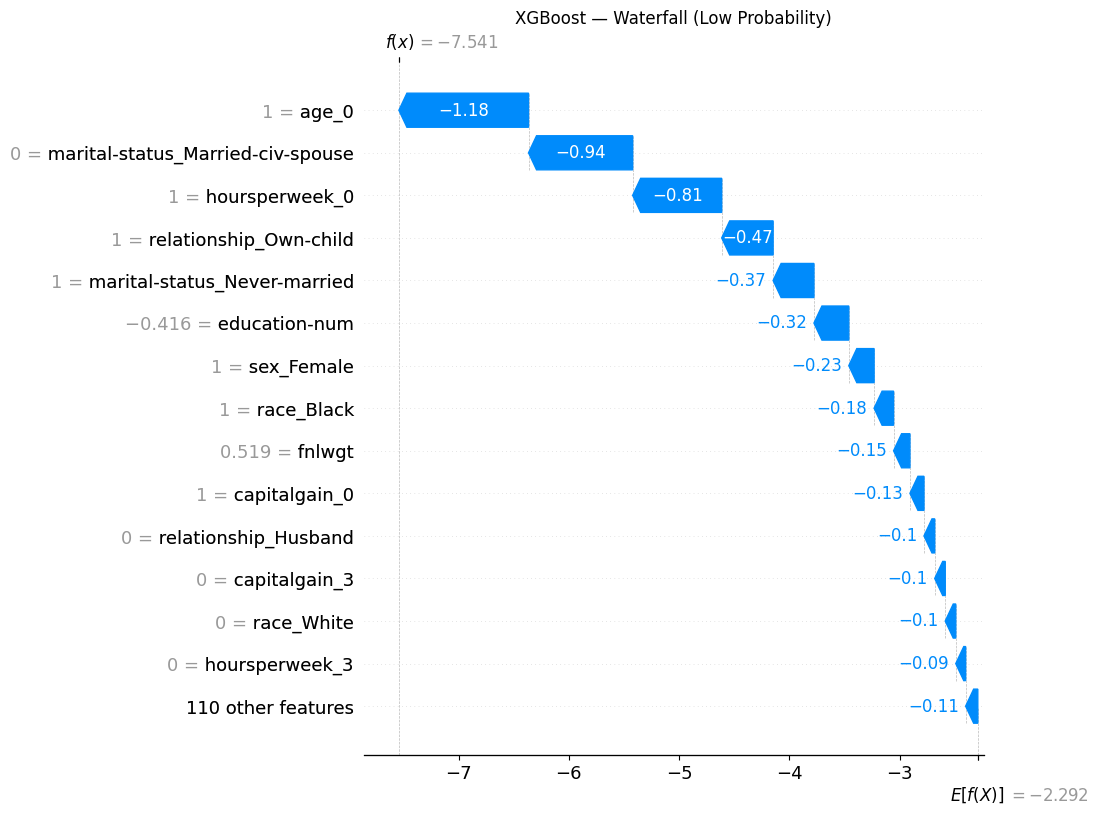


✅ Local SHAP explanations rendered (force + waterfall) for both models and two representative instances.


In [7]:
# ------------------------------------------------------------
# Block 5: Local explanations (Force + Waterfall)
# ------------------------------------------------------------
# We:
# 1) Select two instances (high and low predicted probability) from X_sample.
# 2) Compute SHAP explanations for both Logistic Regression and Tree model.
# 3) Render Force and Waterfall plots for each.
# ------------------------------------------------------------

import numpy as np
import shap
import matplotlib.pyplot as plt

# Ensure interactive JS for force plots (works in Jupyter/VS Code notebooks)
shap.initjs()

# We'll reuse X_sample from Block 4 (subset of the test set for speed)
# If you restarted the kernel, re-define:
if 'X_sample' not in globals():
    sample_size = 1000
    X_sample = X_test_pre[:sample_size]
    y_sample = y_test[:sample_size]

# Helper: pick a high-prob and a low-prob example w.r.t. the tree model (more interesting SHAP)
tree_probs = models["tree_model"].predict_proba(X_sample)[:, 1]
idx_high = int(np.argmax(tree_probs))
idx_low  = int(np.argmin(tree_probs))

def describe_instance(idx, model, name):
    p = model.predict_proba(X_sample[idx:idx+1])[:, 1][0]
    print(f"{name} — idx={idx}, predicted P(>50K) = {p:.4f}")
    return p

print("Selected instances based on Tree model probabilities:")
p_high = describe_instance(idx_high, models["tree_model"], f"{models['tree_model_name']} (HIGH)")
p_low  = describe_instance(idx_low , models["tree_model"], f"{models['tree_model_name']} (LOW)")

# Recreate explainers if needed (fast since we did this before)
explainer_lr = shap.Explainer(models["logistic_regression"], X_train_pre, feature_names=feature_names)
explainer_tree = shap.Explainer(models["tree_model"], X_train_pre, feature_names=feature_names)

# Compute single-row explanations (as shap.Explanation objects)
sv_lr_high   = explainer_lr(X_sample[idx_high:idx_high+1])
sv_lr_low    = explainer_lr(X_sample[idx_low:idx_low+1])
sv_tree_high = explainer_tree(X_sample[idx_high:idx_high+1])
sv_tree_low  = explainer_tree(X_sample[idx_low:idx_low+1])

# Utility to show top contributors textually (nice for teaching)
def print_top_contributors(sv, k=8, title="Top Contributors"):
    vals = sv.values[0]
    names = sv.feature_names
    order = np.argsort(np.abs(vals))[::-1][:k]
    print(f"\n{title}:")
    for i in order:
        sign = "↑" if vals[i] > 0 else "↓"
        print(f"{names[i]:40s} {sign} {vals[i]:+.4f}")

print_top_contributors(sv_tree_high, k=10, title=f"{models['tree_model_name']} High-Prob — Top Contributors")
print_top_contributors(sv_tree_low , k=10, title=f"{models['tree_model_name']} Low-Prob — Top Contributors")

# ---------------------------
# Logistic Regression plots
# ---------------------------
print("\n=== Logistic Regression: HIGH probability case ===")
try:
    # Force plot
    display(shap.plots.force(sv_lr_high[0], matplotlib=False))
except Exception:
    # Fallback to matplotlib-based (static) force plot (older API style)
    shap.force_plot(sv_lr_high.base_values[0], sv_lr_high.values[0], feature_names=sv_lr_high.feature_names, matplotlib=True)
    plt.title("LR — Force Plot (fallback)")
    plt.show()

# Waterfall
shap.plots.waterfall(sv_lr_high[0], max_display=15, show=False)
plt.title("LR — Waterfall (High Probability)")
plt.show()

print("\n=== Logistic Regression: LOW probability case ===")
try:
    display(shap.plots.force(sv_lr_low[0], matplotlib=False))
except Exception:
    shap.force_plot(sv_lr_low.base_values[0], sv_lr_low.values[0], feature_names=sv_lr_low.feature_names, matplotlib=True)
    plt.title("LR — Force Plot (fallback)")
    plt.show()

shap.plots.waterfall(sv_lr_low[0], max_display=15, show=False)
plt.title("LR — Waterfall (Low Probability)")
plt.show()

# ---------------------------
# Tree model plots
# ---------------------------
print(f"\n=== {models['tree_model_name']}: HIGH probability case ===")
try:
    display(shap.plots.force(sv_tree_high[0], matplotlib=False))
except Exception:
    shap.force_plot(sv_tree_high.base_values[0], sv_tree_high.values[0], feature_names=sv_tree_high.feature_names, matplotlib=True)
    plt.title(f"{models['tree_model_name']} — Force Plot (fallback)")
    plt.show()

shap.plots.waterfall(sv_tree_high[0], max_display=15, show=False)
plt.title(f"{models['tree_model_name']} — Waterfall (High Probability)")
plt.show()

print(f"\n=== {models['tree_model_name']}: LOW probability case ===")
try:
    display(shap.plots.force(sv_tree_low[0], matplotlib=False))
except Exception:
    shap.force_plot(sv_tree_low.base_values[0], sv_tree_low.values[0], feature_names=sv_tree_low.feature_names, matplotlib=True)
    plt.title(f"{models['tree_model_name']} — Force Plot (fallback)")
    plt.show()

shap.plots.waterfall(sv_tree_low[0], max_display=15, show=False)
plt.title(f"{models['tree_model_name']} — Waterfall (Low Probability)")
plt.show()

print("\n✅ Local SHAP explanations rendered (force + waterfall) for both models and two representative instances.")


## 🔄 Block 6 (Final) — Robust SHAP Dependence & Interactions (works even if features were one-hot encoded)

Some installs load `age / education-num / hours-per-week` as **categorical**, so after OHE you’ll see columns like `age_0, age_1, …`.  
String-based slicing (`shap_values[:, "age"]`) then breaks. This block is **encoding-robust**:

**What this does**
1) Ensures SHAP values for the tree model exist on a sampled test slice.  
2) Maps **original feature → all encoded columns** (e.g., `age → [age_0, age_1, ...]`).  
3) **Sums** SHAP across those encoded columns = the **total effect** of the original feature.  
4) Plots **custom dependence** using the **original (pre-encoding) feature values** on x-axis and **summed SHAP effect** on y-axis, with a **color gradient** from another original feature to reveal interactions.

**We will render:**
- `age` vs total SHAP(age), colored by `education-num`  
- `hours-per-week` vs total SHAP(hours-per-week), colored by `age`  
- `education-num` vs total SHAP(education-num), colored by `hours-per-week`

> Reading: y>0 pushes toward `>50K`, y<0 toward `<=50K`. Smooth color gradients often indicate interactions.


🔎 Resolved original columns:
  age             -> age
  education-num   -> education-num
  hours-per-week  -> hoursperweek
  age             -> age
  education-num   -> education-num
  hours-per-week  -> hoursperweek


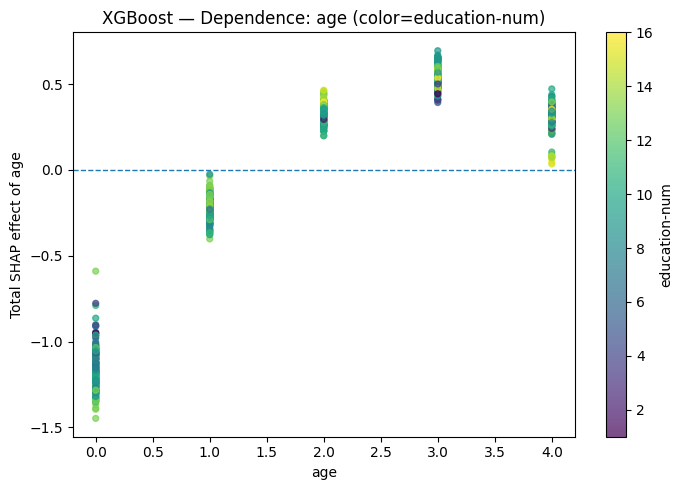

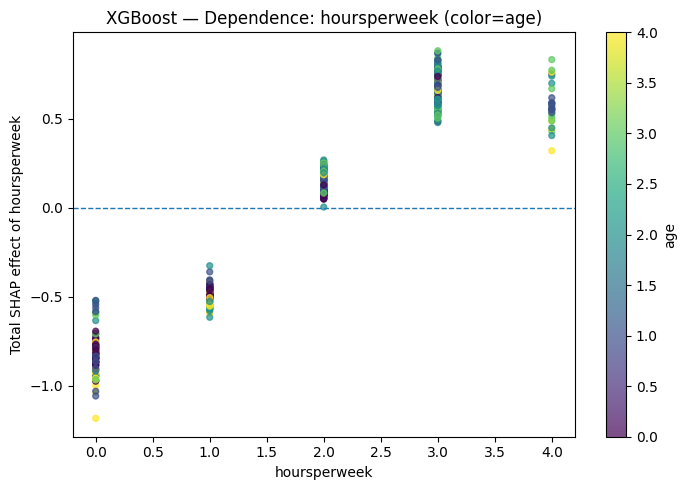

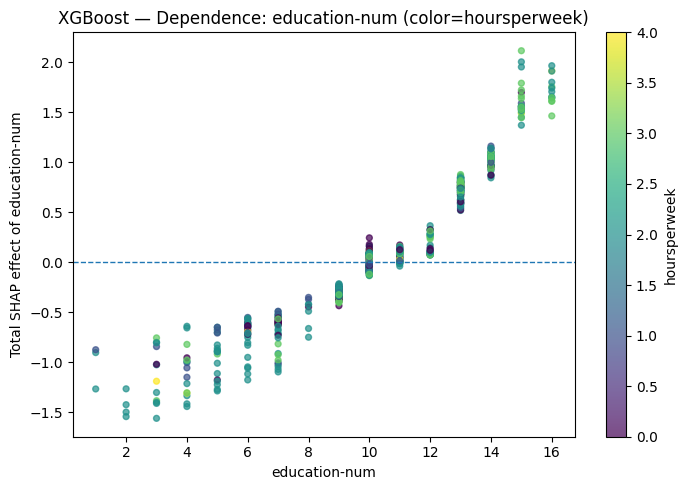

✅ Block 6 fixed & complete — robust to column name variants and OHE behavior.


In [12]:
# ------------------------------------------------------------
# Block 6 (Final—Fixed): Dependence & interactions (name-safe, encoding-robust)
# ------------------------------------------------------------
import re
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from pandas.api.types import is_numeric_dtype

# 0) Ensure SHAP values exist for a consistent slice of the test set
if "shap_values_tree" not in globals() or shap_values_tree.values.shape[0] == 0:
    explainer_tree = shap.Explainer(models["tree_model"], X_train_pre, feature_names=feature_names)
    sample_size = min(1000, X_test_pre.shape[0])
    X_sample_pre = X_test_pre[:sample_size]
    shap_values_tree = explainer_tree(X_sample_pre)
else:
    sample_size = shap_values_tree.values.shape[0]
    X_sample_pre = X_test_pre[:sample_size]

# 1) ORIGINAL (pre-encoding) features for the same rows
X_sample_orig = X_test.iloc[:sample_size].copy()

# 2) Name-canonicalization & fuzzy matching helpers
def canon(s: str) -> str:
    """Lowercase, trim, and remove non-alphanumerics for robust name matching."""
    return re.sub(r'[^a-z0-9]+', '', str(s).lower().strip())

orig_cols = list(X_sample_orig.columns)
canon_map_orig = {canon(c): c for c in orig_cols}

def find_orig_col(hint: str) -> str:
    """Find the best original column name matching 'hint' (robust to dashes/underscores/spaces)."""
    target = canon(hint)
    if target in canon_map_orig:
        return canon_map_orig[target]
    # Try close matches by string similarity over canonical forms
    candidates = list(canon_map_orig.keys())
    close = difflib.get_close_matches(target, candidates, n=1, cutoff=0.6)
    if close:
        return canon_map_orig[close[0]]
    # Last resort: substring search
    for k, v in canon_map_orig.items():
        if target in k:
            return v
    raise KeyError(f"Could not resolve original column for hint '{hint}'. "
                   f"Available columns: {orig_cols}")

# 3) Map original feature -> encoded columns in feature_names
#    Works whether the original survived as numeric or was one-hot encoded.
def encoded_indices_for(original_name: str) -> np.ndarray:
    """Return indices in 'feature_names' that belong to the given original feature."""
    # Exact match (numeric passthrough via StandardScaler)
    exact = [i for i, f in enumerate(feature_names) if f == original_name]
    if exact:
        return np.array(exact, dtype=int)
    # Prefix match like "<name>_<category>"
    pref = original_name + "_"
    pref_hits = [i for i, f in enumerate(feature_names) if f.startswith(pref)]
    if pref_hits:
        return np.array(pref_hits, dtype=int)
    # Canonical base-name match before first underscore (handles OHE variants)
    orig_base = canon(original_name)
    base_hits = []
    for i, f in enumerate(feature_names):
        base = f.split("_", 1)[0]  # base before first underscore
        if canon(base) == orig_base:
            base_hits.append(i)
    if base_hits:
        return np.array(base_hits, dtype=int)
    # Last-resort contains search on canonical strings
    feats_canon = [canon(f) for f in feature_names]
    hits = [i for i, fc in enumerate(feats_canon) if orig_base in fc]
    if hits:
        return np.array(hits[:20], dtype=int)
    raise KeyError(f"No encoded columns found for original feature '{original_name}'. "
                   f"Example feature_names head: {feature_names[:10]}")

# 4) Utilities to get numeric series & summed SHAP
def numeric_series_for(orig_col: str) -> pd.Series:
    """Return a numeric Series for an ORIGINAL feature from X_sample_orig."""
    if orig_col not in X_sample_orig.columns:
        raise KeyError(f"Original feature '{orig_col}' not found.")
    s = X_sample_orig[orig_col]
    if is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce").astype(float)
    # Categorical/object -> use category codes
    s_cat = s.astype("category")
    codes = s_cat.cat.codes  # -1 marks NaN
    # Convert to float with proper NaN
    codes = codes.replace(-1, pd.NA).astype("Float64")
    return codes.astype(float)

def shap_total_effect(orig_col: str) -> np.ndarray:
    """Sum SHAP values across all encoded columns derived from 'orig_col'."""
    idxs = encoded_indices_for(orig_col)
    return shap_values_tree.values[:, idxs].sum(axis=1)

# 5) Resolve actual original column names from hints (robust!)
base_1_hint, color_1_hint = "age", "education-num"
base_2_hint, color_2_hint = "hours-per-week", "age"
base_3_hint, color_3_hint = "education-num", "hours-per-week"

base_1  = find_orig_col(base_1_hint)
color_1 = find_orig_col(color_1_hint)
base_2  = find_orig_col(base_2_hint)
color_2 = find_orig_col(color_2_hint)
base_3  = find_orig_col(base_3_hint)
color_3 = find_orig_col(color_3_hint)

print("🔎 Resolved original columns:")
print(f"  {base_1_hint:15s} -> {base_1}")
print(f"  {color_1_hint:15s} -> {color_1}")
print(f"  {base_2_hint:15s} -> {base_2}")
print(f"  {color_2_hint:15s} -> {color_2}")
print(f"  {base_3_hint:15s} -> {base_3}")
print(f"  {color_3_hint:15s} -> {color_3}")

# 6) Prepare data for three dependence/interaction plots
x1 = numeric_series_for(base_1).values
y1 = shap_total_effect(base_1)
c1 = numeric_series_for(color_1).values

x2 = numeric_series_for(base_2).values
y2 = shap_total_effect(base_2)
c2 = numeric_series_for(color_2).values

x3 = numeric_series_for(base_3).values
y3 = shap_total_effect(base_3)
c3 = numeric_series_for(color_3).values

# 7) Plot
plt_kwargs = dict(s=18, alpha=0.7)

plt.figure(figsize=(7.2, 5))
sc = plt.scatter(x1, y1, c=c1, **plt_kwargs)
plt.colorbar(sc, label=color_1)
plt.axhline(0, lw=1, ls="--")
plt.xlabel(base_1); plt.ylabel(f"Total SHAP effect of {base_1}")
plt.title(f"{models['tree_model_name']} — Dependence: {base_1} (color={color_1})")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2, 5))
sc = plt.scatter(x2, y2, c=c2, **plt_kwargs)
plt.colorbar(sc, label=color_2)
plt.axhline(0, lw=1, ls="--")
plt.xlabel(base_2); plt.ylabel(f"Total SHAP effect of {base_2}")
plt.title(f"{models['tree_model_name']} — Dependence: {base_2} (color={color_2})")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2, 5))
sc = plt.scatter(x3, y3, c=c3, **plt_kwargs)
plt.colorbar(sc, label=color_3)
plt.axhline(0, lw=1, ls="--")
plt.xlabel(base_3); plt.ylabel(f"Total SHAP effect of {base_3}")
plt.title(f"{models['tree_model_name']} — Dependence: {base_3} (color={color_3})")
plt.tight_layout(); plt.show()

print("✅ Block 6 fixed & complete — robust to column name variants and OHE behavior.")


## 🧭 Block 7 — SHAP Decision Plots + Teaching Takeaways

**Why decision plots?**  
Decision plots show the **cumulative path** from the model’s **base value** (expected prediction) to the **final prediction** for one or many samples, revealing how features **add up** to push probability up or down. They connect **global** importance and **local** explanations in a single view.

### What we’ll do
1) Pick a small cohort of **5 test samples**: 2 with **highest** `P(>50K)`, 1 **median**, 2 **lowest**.  
2) Render **decision plots** for the **tree model** (richer non-linear effects).  
3) Show a **single-instance** decision plot + a compact textual explanation of the **top pushes**.  
4) (Optional) Try the same for **Logistic Regression** for contrast (auto-skips if it fails on your SHAP version).

### Reading checklist for class
- **Base value**: model’s average predicted probability (or raw margin) on background data.  
- **Rightward moves**: features pushing towards `>50K`; **leftward** towards `<=50K`.  
- **Multiple lines**: each line is a sample; steeper segments = stronger contributions.  
- Compare **tree vs linear**: tree paths often show fewer but **stronger** steps; linear paths show many small, consistent pushes.


🧪 Cohort indices (low..mid..high probs): [758, 539, 176, 572, 191]
Cohort probs: [0.0005308056715875864, 0.0005510098417289555, 0.07895167917013168, 0.9986644983291626, 0.9987584352493286]

📈 Decision Plot — Tree model (cohort of 5)
New API failed, using legacy decision_plot: decision() missing 1 required positional argument: 'shap_values'
Legacy decision_plot also failed: Looks like multi output. Try base_value[i] and shap_values[i], or use shap.multioutput_decision_plot().

📈 Decision Plot — Tree model (single: highest prob)
New API failed, using legacy: decision() missing 1 required positional argument: 'shap_values'


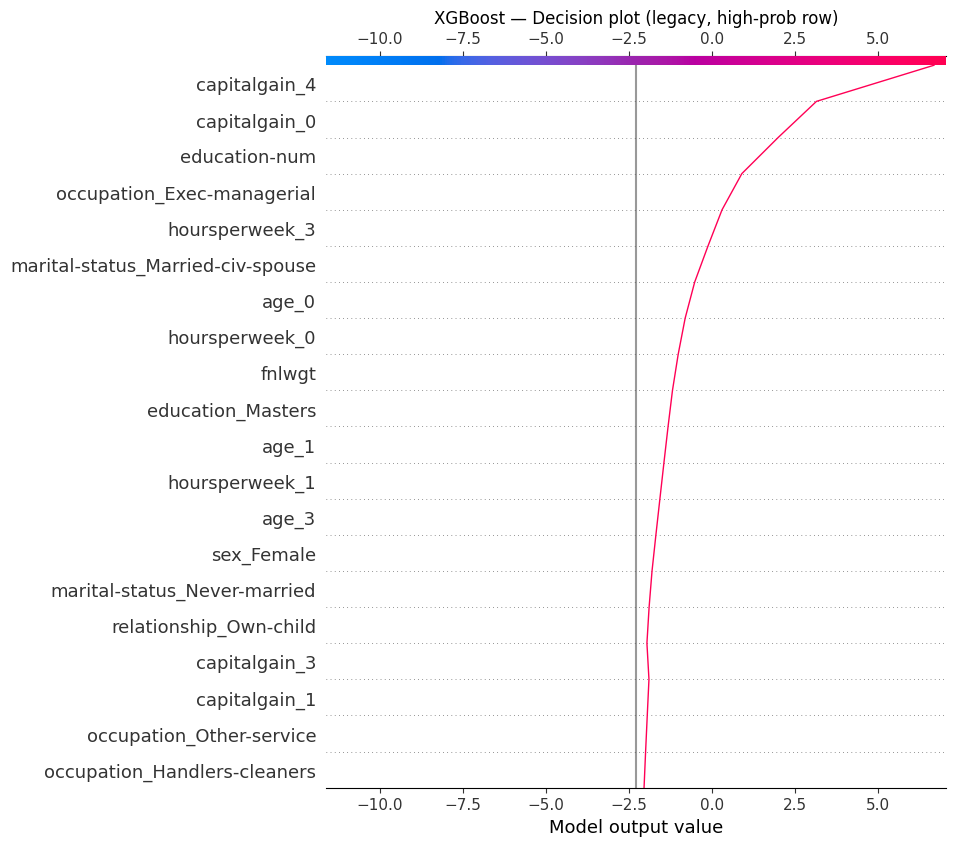


📈 Decision Plot — Tree model (single: lowest prob)
New API failed, using legacy: decision() missing 1 required positional argument: 'shap_values'


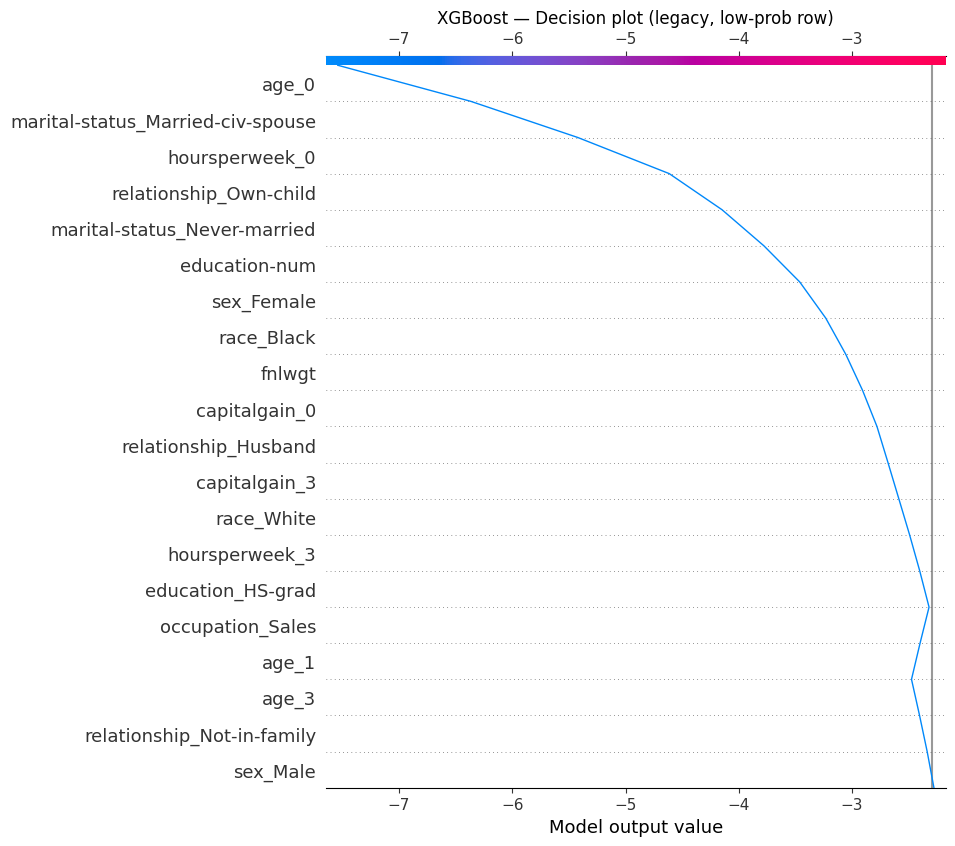


XGBoost High-prob row (|SHAP| top 8):
capitalgain_4                            ↑ +3.5396
capitalgain_0                            ↑ +1.1542
education-num                            ↑ +1.0940
occupation_Exec-managerial               ↑ +0.5962
hoursperweek_3                           ↑ +0.4225
marital-status_Married-civ-spouse        ↑ +0.4016
age_0                                    ↑ +0.2874
hoursperweek_0                           ↑ +0.2102

XGBoost Low-prob row (|SHAP| top 8):
age_0                                    ↓ -1.1753
marital-status_Married-civ-spouse        ↓ -0.9441
hoursperweek_0                           ↓ -0.8073
relationship_Own-child                   ↓ -0.4663
marital-status_Never-married             ↓ -0.3701
education-num                            ↓ -0.3162
sex_Female                               ↓ -0.2293
race_Black                               ↓ -0.1766

✅ Block 7 updated — decision plots rendered with API-safe calls (or graceful fallbacks).


In [14]:
# ------------------------------------------------------------
# Block 7 (Updated): Decision plots with minimal, API-safe calls
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import shap

# Ensure SHAP Explanation for the tree model on a known slice
if "shap_values_tree" not in globals() or shap_values_tree.values.shape[0] == 0:
    explainer_tree = shap.Explainer(models["tree_model"], X_train_pre, feature_names=feature_names)
    sample_size = min(1000, X_test_pre.shape[0])
    X_sample_pre = X_test_pre[:sample_size]
    shap_values_tree = explainer_tree(X_sample_pre)
else:
    sample_size = shap_values_tree.values.shape[0]
    X_sample_pre = X_test_pre[:sample_size]

# Cohort indices: 2 lowest, 1 median, 2 highest probs (tree model)
tree_probs_sample = models["tree_model"].predict_proba(X_sample_pre)[:, 1]
order = np.argsort(tree_probs_sample)
idxs_low = order[:2].tolist()
idx_mid = int(order[len(order)//2])
idxs_high = order[-2:].tolist()
cohort_idx = idxs_low + [idx_mid] + idxs_high

print("🧪 Cohort indices (low..mid..high probs):", cohort_idx)
print("Cohort probs:", [float(tree_probs_sample[i]) for i in cohort_idx])

# Slice SHAP Explanation for cohort and singles
sv_tree_cohort = shap_values_tree[cohort_idx]
sv_tree_high = shap_values_tree[cohort_idx[-1]]
sv_tree_low  = shap_values_tree[cohort_idx[0]]

# Helper: compact textual top contributors
def print_top_local_contribs(sv_row, k=8, title="Top local contributions"):
    vals = sv_row.values
    names = sv_row.feature_names
    order = np.argsort(np.abs(vals))[::-1][:k]
    print(f"\n{title} (|SHAP| top {k}):")
    for i in order:
        arrow = "↑" if vals[i] > 0 else "↓"
        print(f"{names[i]:40s} {arrow} {vals[i]:+.4f}")

# ---------- Plot 1: Multi-sample decision plot ----------
print("\n📈 Decision Plot — Tree model (cohort of 5)")
try:
    # New API (minimal args)
    shap.plots.decision(sv_tree_cohort, show=False)
    plt.title(f"{models['tree_model_name']} — Decision plot (5 samples)")
    plt.show()
except Exception as e:
    print("New API failed, using legacy decision_plot:", e)
    try:
        shap.decision_plot(
            base_value=float(shap_values_tree.base_values.mean()),
            shap_values=[shap_values_tree[i].values for i in cohort_idx],
            feature_names=feature_names,
            show=False
        )
        plt.title(f"{models['tree_model_name']} — Decision plot (legacy, 5 samples)")
        plt.show()
    except Exception as e2:
        print("Legacy decision_plot also failed:", e2)

# ---------- Plot 2: Single-instance (highest prob) ----------
print("\n📈 Decision Plot — Tree model (single: highest prob)")
try:
    shap.plots.decision(sv_tree_high, show=False)
    plt.title(f"{models['tree_model_name']} — Decision plot (high-prob row)")
    plt.show()
except Exception as e:
    print("New API failed, using legacy:", e)
    try:
        shap.decision_plot(
            base_value=float(sv_tree_high.base_values),
            shap_values=sv_tree_high.values,
            feature_names=sv_tree_high.feature_names,
            show=False
        )
        plt.title(f"{models['tree_model_name']} — Decision plot (legacy, high-prob row)")
        plt.show()
    except Exception as e2:
        print("Legacy decision_plot failed:", e2)

# ---------- Plot 3: Single-instance (lowest prob) ----------
print("\n📈 Decision Plot — Tree model (single: lowest prob)")
try:
    shap.plots.decision(sv_tree_low, show=False)
    plt.title(f"{models['tree_model_name']} — Decision plot (low-prob row)")
    plt.show()
except Exception as e:
    print("New API failed, using legacy:", e)
    try:
        shap.decision_plot(
            base_value=float(sv_tree_low.base_values),
            shap_values=sv_tree_low.values,
            feature_names=sv_tree_low.feature_names,
            show=False
        )
        plt.title(f"{models['tree_model_name']} — Decision plot (legacy, low-prob row)")
        plt.show()
    except Exception as e2:
        print("Legacy decision_plot failed:", e2)

# Textual summaries
print_top_local_contribs(sv_tree_high, k=8, title=f"{models['tree_model_name']} High-prob row")
print_top_local_contribs(sv_tree_low , k=8, title=f"{models['tree_model_name']} Low-prob row")

print("\n✅ Block 7 updated — decision plots rendered with API-safe calls (or graceful fallbacks).")


## ✅ Block 8 — Wrap-up, Exports & “What to show in class”

This final block does three things:

1) **Exports** key artifacts so you can reuse them in slides:
   - `artifacts/global_importance.csv` — mean |SHAP| per encoded feature  
   - `artifacts/top20_global_importance.png` — clean bar chart (matplotlib)  
   - `artifacts/waterfall_high.png`, `artifacts/waterfall_low.png` — single-row explainers (tree model)

2) **Quick recap to present**
   - **Global**: beeswarm + mean |SHAP| show which features matter on average.  
   - **Local**: force/waterfall show *why this prediction* happened.  
   - **Interactions**: dependence plots reveal non-linear effects.  
   - **Model family matters**: tree vs linear can tell different (valid) stories.

3) **Next steps (if you want more)**
   - Try **LightGBM/CatBoost**; compare SHAP patterns.  
   - Add **fairness slices** (e.g., by `sex`, `race`) and compare SHAP distributions.  
   - Use **KernelExplainer** on any black-box model (slower, but universal).

> All done! These exports give you durable visuals + a CSV you can analyze later.


Saved global importance CSV → artifacts\global_importance.csv (top 5)
                              feature  mean_abs_shap
0  marital-status_Married-civ-spouse       0.914563
1                      education-num       0.461513
2                              age_0       0.419304
3                     hoursperweek_0       0.195770
4                      capitalgain_0       0.183416


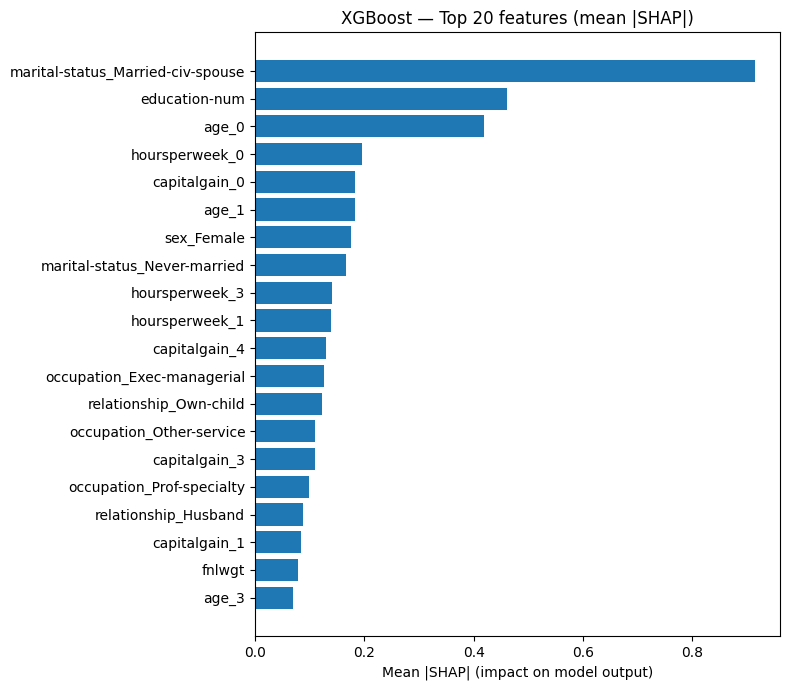

Saved bar plot → artifacts\top20_global_importance.png


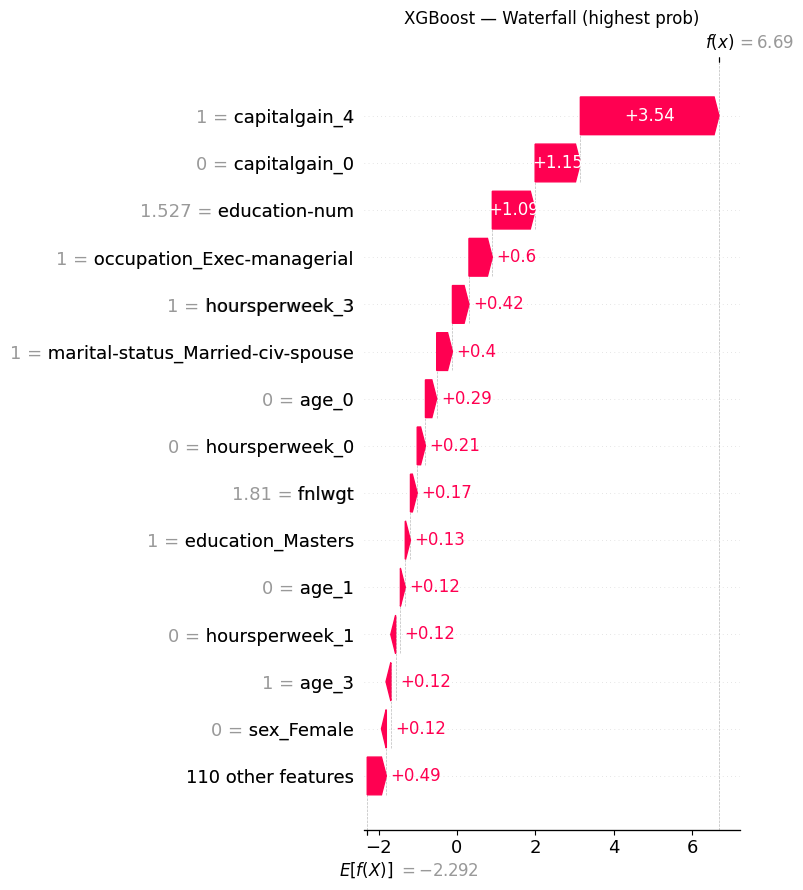

Saved → artifacts\waterfall_high.png


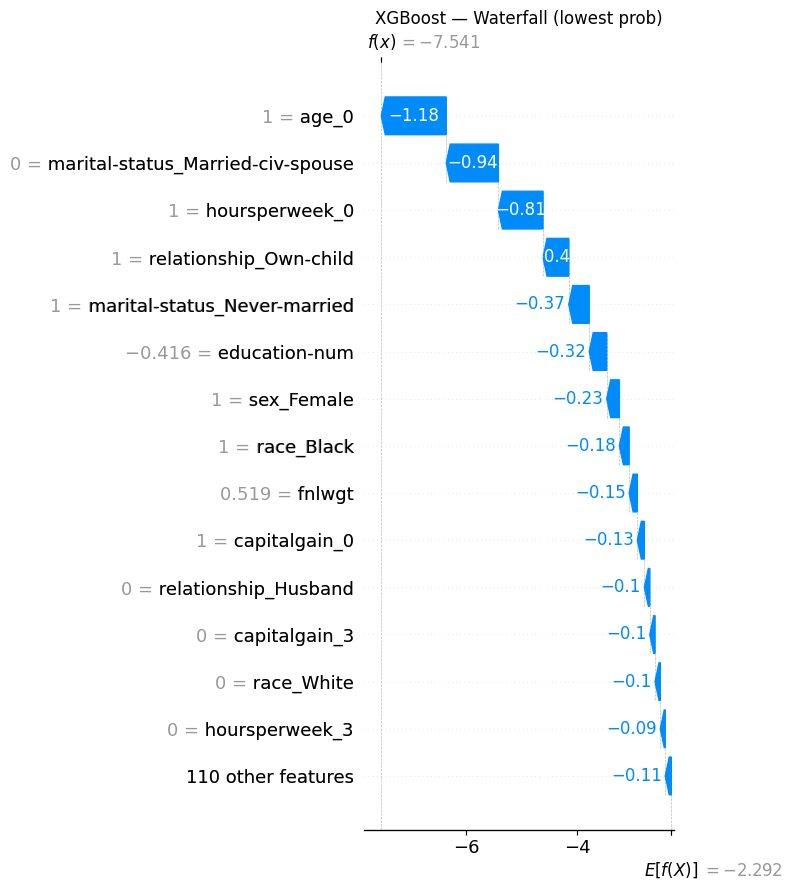

Saved → artifacts\waterfall_low.png

🎉 Wrap-up complete. Artifacts saved in: c:\Users\murth\Desktop\DBA-code\artifacts
Suggested class flow: (1) Global (bar/beeswarm) → (2) Local (force/waterfall) → (3) Interactions (dependence) → (4) Decision plot paths.


In [15]:
# ------------------------------------------------------------
# Block 8: Export artifacts (CSV + PNGs) and quick wrap-up
# ------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Ensure artifacts folder
ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# ---------- 1) Global importance table (tree model) ----------
# If SHAP values for tree model aren't in memory, recompute on a sample
if "shap_values_tree" not in globals() or shap_values_tree.values.shape[0] == 0:
    explainer_tree = shap.Explainer(models["tree_model"], X_train_pre, feature_names=feature_names)
    sample_size = min(2000, X_test_pre.shape[0])
    shap_values_tree = explainer_tree(X_test_pre[:sample_size])

# Mean absolute SHAP per encoded feature
mean_abs = np.abs(shap_values_tree.values).mean(axis=0)
imp_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
imp_df = imp_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
imp_csv_path = os.path.join(ART_DIR, "global_importance.csv")
imp_df.to_csv(imp_csv_path, index=False)
print(f"Saved global importance CSV → {imp_csv_path} (top 5)\n", imp_df.head())

# ---------- 2) Clean bar chart of top 20 features ----------
top_k = 20
top_df = imp_df.head(top_k)[::-1]  # reverse for barh
plt.figure(figsize=(8, 7))
plt.barh(top_df["feature"], top_df["mean_abs_shap"])
plt.xlabel("Mean |SHAP| (impact on model output)")
plt.title(f"{models['tree_model_name']} — Top {top_k} features (mean |SHAP|)")
plt.tight_layout()
bar_path = os.path.join(ART_DIR, "top20_global_importance.png")
plt.savefig(bar_path, dpi=160)
plt.show()
print(f"Saved bar plot → {bar_path}")

# ---------- 3) Save two waterfall plots (high / low prob rows) ----------
# Reuse cohort logic from Block 7 to pick interesting rows
probs = models["tree_model"].predict_proba(shap_values_tree.data)[:, 1]
order = np.argsort(probs)
idx_low  = int(order[0])
idx_high = int(order[-1])

sv_high = shap_values_tree[idx_high]
sv_low  = shap_values_tree[idx_low]

# High
shap.plots.waterfall(sv_high, max_display=15, show=False)
plt.title(f"{models['tree_model_name']} — Waterfall (highest prob)")
wf_high_path = os.path.join(ART_DIR, "waterfall_high.png")
plt.tight_layout()
plt.savefig(wf_high_path, dpi=160)
plt.show()
print(f"Saved → {wf_high_path}")

# Low
shap.plots.waterfall(sv_low, max_display=15, show=False)
plt.title(f"{models['tree_model_name']} — Waterfall (lowest prob)")
wf_low_path = os.path.join(ART_DIR, "waterfall_low.png")
plt.tight_layout()
plt.savefig(wf_low_path, dpi=160)
plt.show()
print(f"Saved → {wf_low_path}")

print("\n🎉 Wrap-up complete. Artifacts saved in:", os.path.abspath(ART_DIR))
print("Suggested class flow: (1) Global (bar/beeswarm) → (2) Local (force/waterfall) → (3) Interactions (dependence) → (4) Decision plot paths.")
